In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, (2, 3)]
y = iris.target

In [2]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="chapter_6_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [4]:
import os

# using Graphviz 
os.system("dot -Tpng chapter_6_tree.dot -o chapter_6_tree.png")

0

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_dec_bound(clf, X, y, axes, quality=200):
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], quality),
        np.linspace(axes[2], axes[3], quality)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]

    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.2, cmap=plt.cm.brg)
    plt.contour(x1, x2, y_pred, alpha=0.8, cmap=plt.cm.brg)

    y_opt = len(pd.DataFrame(y).value_counts())
    for i in range(y_opt):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], ".", label=fr"$class{i+1}$")
    plt.legend()
    plt.axis(axes)

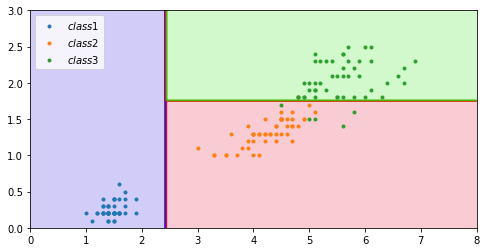

In [6]:
import numpy as np

plt.figure(figsize=(8, 4))
plot_dec_bound(tree_clf, X, y, [0, 8, 0, 3])

In [7]:
import numpy as np

# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [9]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_reg,
    out_file="chapter_6_tree_2.dot",
    rounded=True,
    filled=True
)

In [10]:
import os

# using Graphviz 
os.system("dot -Tpng chapter_6_tree_2.dot -o chapter_6_tree_2.png")

0

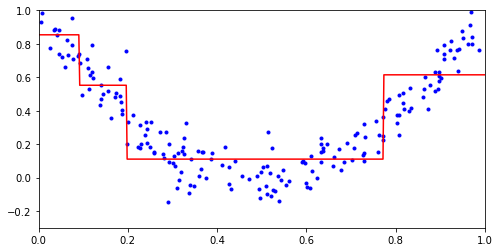

In [11]:
def plot_reg_pred(reg, X, y, axes, quality=500):
    x1 = np.linspace(axes[0], axes[1], quality).reshape(-1, 1)
    y_pred = reg.predict(x1)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r-")
    plt.axis(axes)

plt.figure(figsize=(8, 4))
plot_reg_pred(tree_reg, X, y, [0, 1, -0.3, 1])
plt.show()

# EXERICES

In [12]:
from sklearn.datasets import make_moons

data = make_moons(n_samples=10000, noise=0.4)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.2)

In [14]:
len(pd.DataFrame(y).value_counts())

200

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 8, 9, 10, 11],
    "min_samples_split": [2, 3, 5, 8, 10, 20],
    "min_samples_leaf": [1, 2, 3, 5, 10, 20],
    "max_leaf_nodes": list(range(2, 100)),
}
grid = GridSearchCV(clf, params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8, 9, 10, 11],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_leaf': [1, 2, 3, 5, 10, 20],
                         'min_samples_split': [2, 3, 5, 8, 10, 20]})

In [18]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_leaf_nodes': 59,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [19]:
from sklearn.metrics import accuracy_score

y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.865

In [25]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1000, test_size = len(X_train) - 100, random_state=42)

mini_sets = []
for train_idx, test_idx in split.split(X_train, y_train):
    mini_sets.append((X_train[train_idx], y_train[train_idx]))

In [27]:
params = grid.best_params_

In [28]:
forest = []
for X_train_mini, y_train_mini in mini_sets:
    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train_mini, y_train_mini)
    forest.append(clf)

In [31]:
from scipy.stats import mode

preds = []
for clf in forest:
    preds.append(clf.predict(X_test))

In [32]:
majority_votes, n_votes = mode(preds, axis=0)

In [36]:
accuracy_score(y_test, majority_votes.reshape(-1, 1))

# this tree isn't the best as we can see

0.809